In [3]:
import os
import re
import sys
import math
import numpy as np
import pandas as pd
from scipy.stats import describe

# Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
%matplotlib inline

from wordcloud import WordCloud
import networkx as nx

In [4]:
# Data files

# article_id, article_url
SRC_ARTICLES = '../data/guardian-100000/articles-100000.csv'

# author_id, comment_author
SRC_AUTHORS = '../data/guardian-100000/authors-100000.csv'

# article_id, author_id, comment_id, comment_text, parent_comment_id, timestamp, upvotes
SRC_COMMENTS = '../data/guardian-100000/sorted_comments-100000.csv'

OUTPUT_DIR = './intro-plots'

In [5]:
articles_df = pd.read_csv(SRC_ARTICLES)
authors_df = pd.read_csv(SRC_AUTHORS)
comments_df = pd.read_csv(SRC_COMMENTS)

##### Utils functions

In [6]:
def adjacency_matrix(article_id):
    # Collect data
    article_comments = comments_df[comments_df['article_id'] == article_id]
    edges = article_comments[['comment_id', 'parent_comment_id']]
    text_lengths = list(article_comments['comment_text'].str.len())
    having_parent_comment = list(article_comments['parent_comment_id'].str.isdigit() == True)
    
    # Transform edges into adjacency matrix
    index_to_id_map = dict(enumerate(article_comments['comment_id']))
    id_to_index_map = dict((y, x) for (x, y) in index_to_id_map.items())
    
    comment_amount = len(article_comments)
    adj_matrix = np.zeros((comment_amount, comment_amount))
    for index, (source, target) in edges.iterrows():
        # If there is no parent comment don't create a graph connection
        if not str(target).isdigit():
            continue
        # Do the same for invalid parent ids
        if not target in id_to_index_map:
            # e.g. there is not comment with id '14593723' at all.
            continue
        from_ = id_to_index_map[source]
        to_ = id_to_index_map[target]
        adj_matrix[from_, to_] = 1
    return pd.DataFrame(adj_matrix), text_lengths, having_parent_comment

def plot_relations_graph(article_id, adj_matrix, node_weights, nodes_is_start):
    G = nx.from_pandas_adjacency(adj_matrix)
    G.name = 'Comments relations'
    pos=nx.spring_layout(G, scale=10)
    
    # Output stats and visualization
    with open(os.path.join(OUTPUT_DIR, 'comment_relations_{}.stats'.format(article_id)), 'w') as f:
        f.write(nx.info(G))
        print(nx.info(G))
        f.write('\nDescribe text length:\nObservations={}\nMin-Max={}\nMean={}\nVar={}\nSkewness={}\nKurtosis={}'.format(*describe(node_weights)))
        print('\nDescribe text length:\nObservations={}\nMin-Max={}\nMean={}\nVar={}\nSkewness={}\nKurtosis={}'.format(*describe(node_weights)))
    # Adjust node sizes determining on the comments text length
    plt.figure(figsize=(12,12))
    nx.draw(G, pos, node_size=[x**0.7 for x in node_weights], node_color=nodes_is_start)
    plt.savefig(os.path.join(OUTPUT_DIR, 'comment_relations_{}.pdf'.format(article_id)))

def analyse_relations(article_id):
    adj_matrix, node_weights, nodes_is_start = adjacency_matrix(article_id)
    plot_relations_graph(article_id, adj_matrix, node_weights, nodes_is_start)

##### Amount of comments in articles

In [7]:
comments_by_articles = comments_df.groupby('article_id').describe()
articles_comments = comments_by_articles['author_id', 'count']
# top 5 most popular articles
articles_comments.sort_values(0, ascending=False).head(5)

article_id
1218    947.0
1164    937.0
1170    902.0
1159    879.0
1110    859.0
Name: (author_id, count), dtype: float64

##### Amount of comments per author

In [221]:
comments_by_authors = comments_df.groupby('author_id').describe()
authors_comments = comments_by_authors['article_id', 'count']
# top 5 most active comment authors
authors_comments.sort_values(0, ascending=False).head(5)

author_id
154     346.0
768     174.0
2055    164.0
398     154.0
405     135.0
Name: (article_id, count), dtype: float64

##### Looking for specific comments based on content

In [5]:
short_comments = comments_df[comments_df['comment_text'].str.len() < 200]
short_comments[short_comments['comment_text'].str.contains('Merkel')][['article_id', 'author_id', 'comment_text', 'upvotes']]

,article_id,author_id,comment_text,upvotes
75077,1151,24648,Nah... it was obviously the Russians... ... I...,1
76201,1159,25085,You mean that Merkel is not as good a leader a...,1
85622,1197,28289,Facebook is happy to cozy up to Merkel and rel...,4
98335,1251,32130,[ Trump has a point with Merkel's migrant poli...,4


##### Word Cloud - comment text

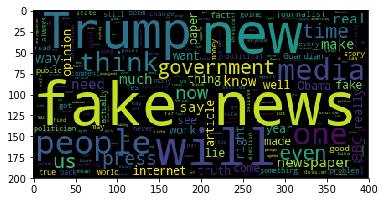

In [6]:
wordcloud = WordCloud().generate(' '.join(comments_df['comment_text'].tail(1000)))
plt.imshow(wordcloud)

##### Word Cloud - author names

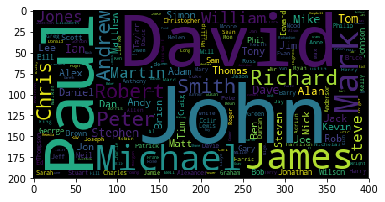

In [223]:
# Replace all characters not matching letters and numbers with a whitespace
authors_name_parts = re.sub(r'[^a-zA-Z0-9]', ' ', ' '.join(authors_df['comment_author']))
wordcloud = WordCloud().generate(authors_name_parts)
plt.imshow(wordcloud)

##### Analyse relations between comment

Name: Comments relations
Type: Graph
Number of nodes: 115
Number of edges: 68
Average degree:   1.1826

Describe text length:
Observations=115
Min-Max=(19, 3093)
Mean=675.8173913043478
Var=338362.18565980165
Skewness=1.6327639052145497
Kurtosis=2.7410879514108304


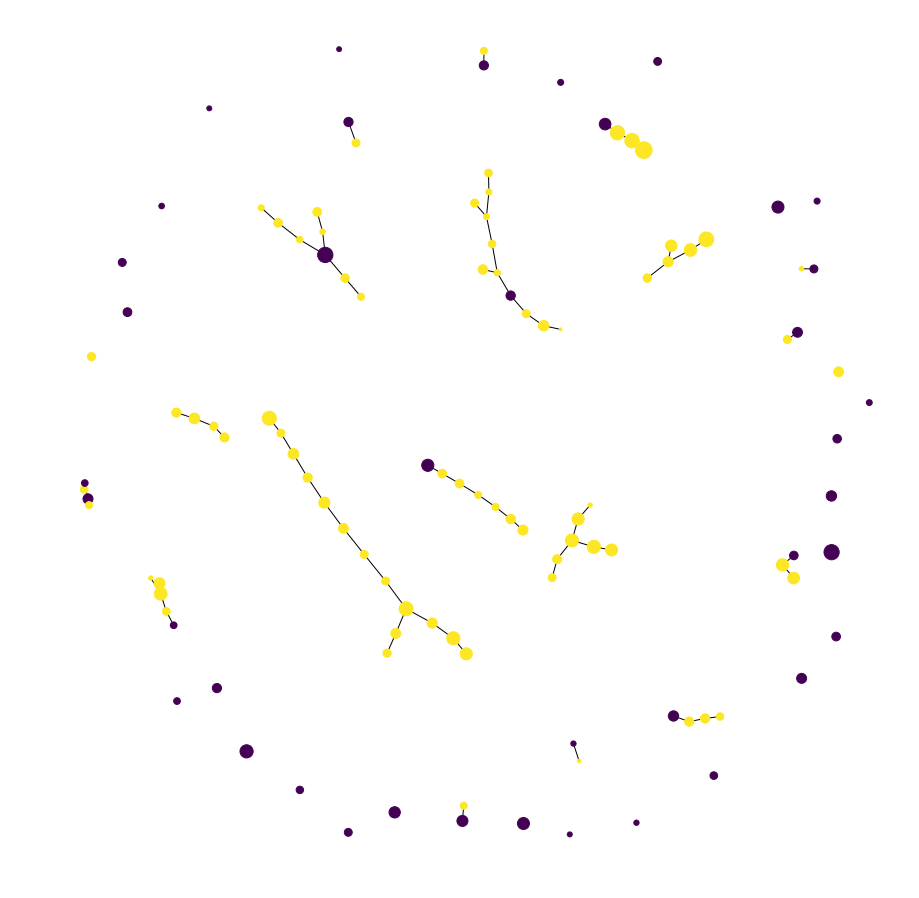

In [8]:
analyse_relations(1)

Name: Comments relations
Type: Graph
Number of nodes: 316
Number of edges: 231
Average degree:   1.4620

Describe text length:
Observations=316
Min-Max=(8, 3500)
Mean=512.5284810126582
Var=213338.5801386377
Skewness=2.788418696581685
Kurtosis=12.404849233121023


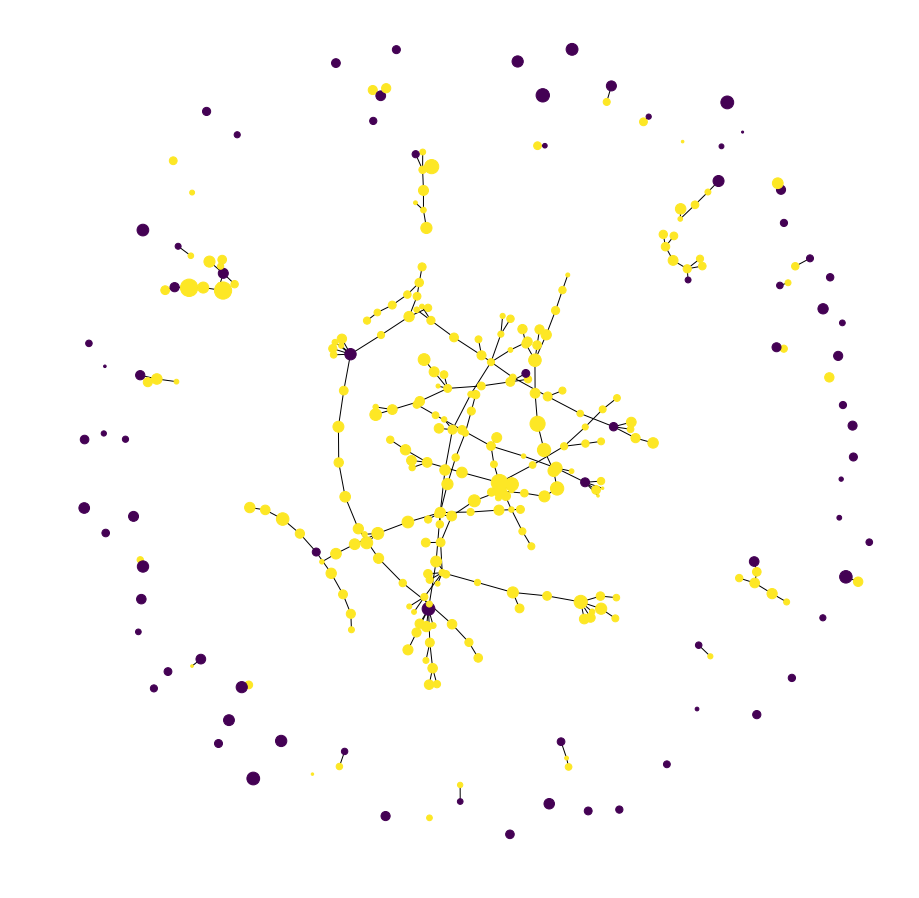

In [9]:
analyse_relations(10)

Name: Comments relations
Type: Graph
Number of nodes: 40
Number of edges: 8
Average degree:   0.4000

Describe text length:
Observations=40
Min-Max=(29, 1383)
Mean=350.2
Var=103242.52307692307
Skewness=1.7309803156156813
Kurtosis=2.984865594909002


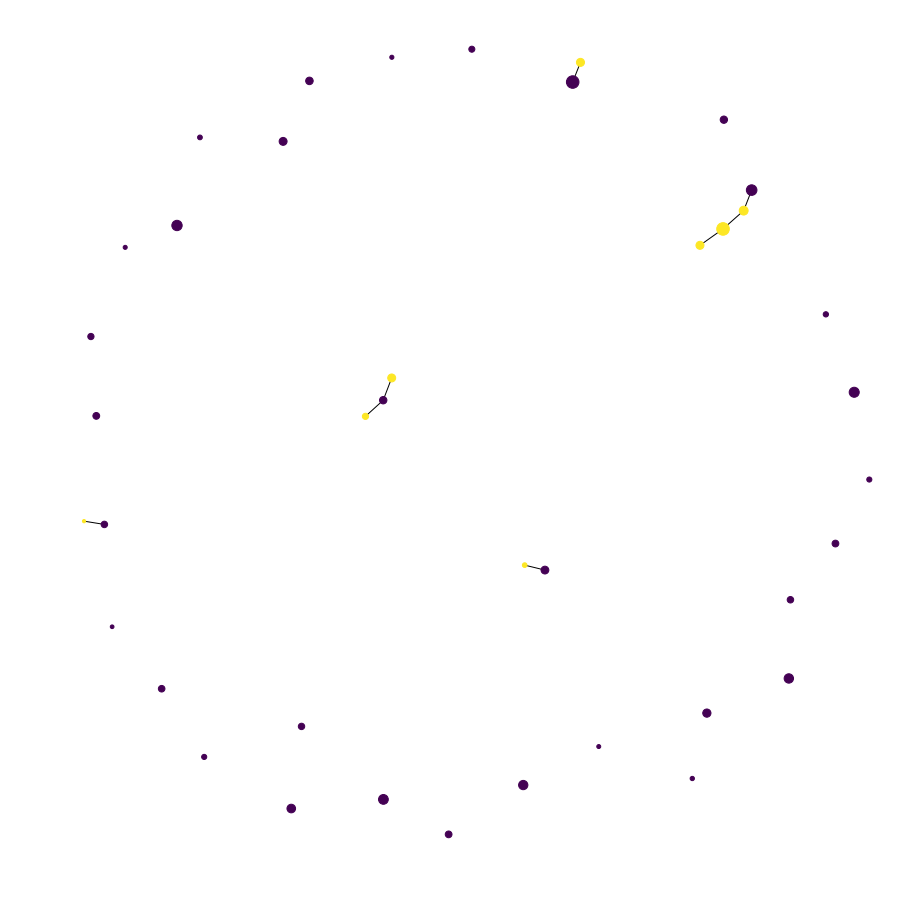

In [10]:
analyse_relations(100)

Name: Comments relations
Type: Graph
Number of nodes: 25
Number of edges: 0
Average degree:   0.0000

Describe text length:
Observations=25
Min-Max=(53, 1144)
Mean=464.0
Var=101458.91666666667
Skewness=0.5349252094056879
Kurtosis=-0.9229545193204798


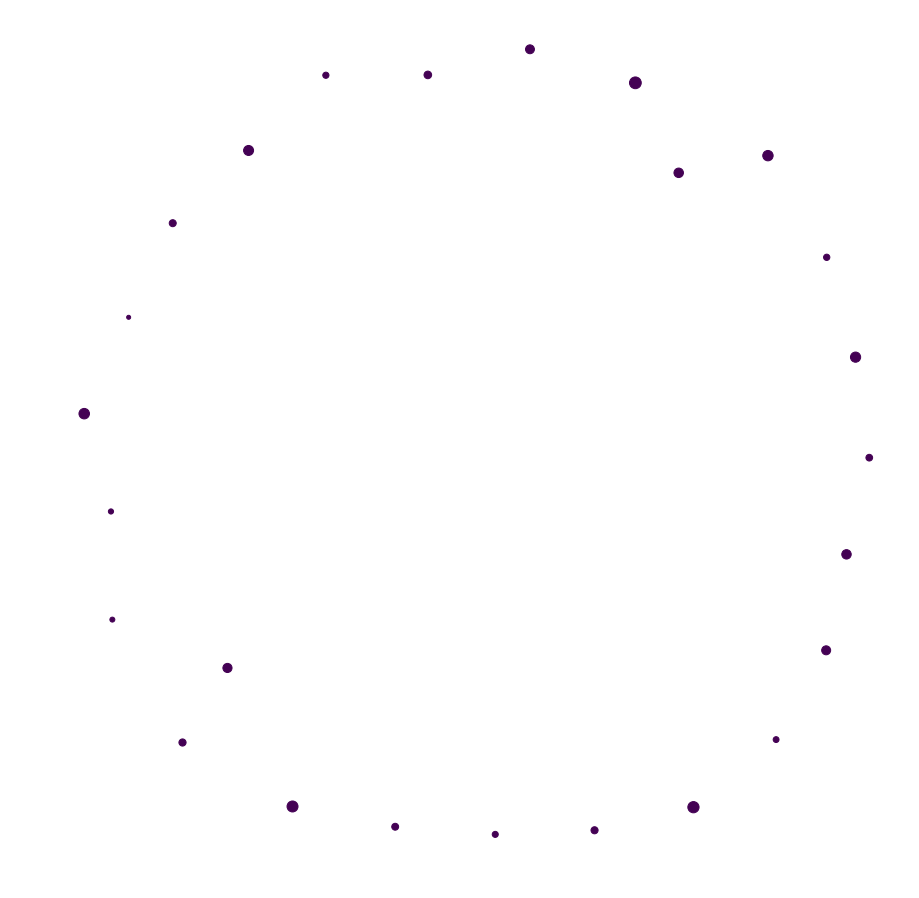

In [12]:
analyse_relations(1001)

Name: Comments relations
Type: Graph
Number of nodes: 859
Number of edges: 526
Average degree:   1.2247

Describe text length:
Observations=859
Min-Max=(2, 3214)
Mean=236.57741559953433
Var=71971.39813736903
Skewness=3.84469898281567
Kurtosis=26.44802404193496


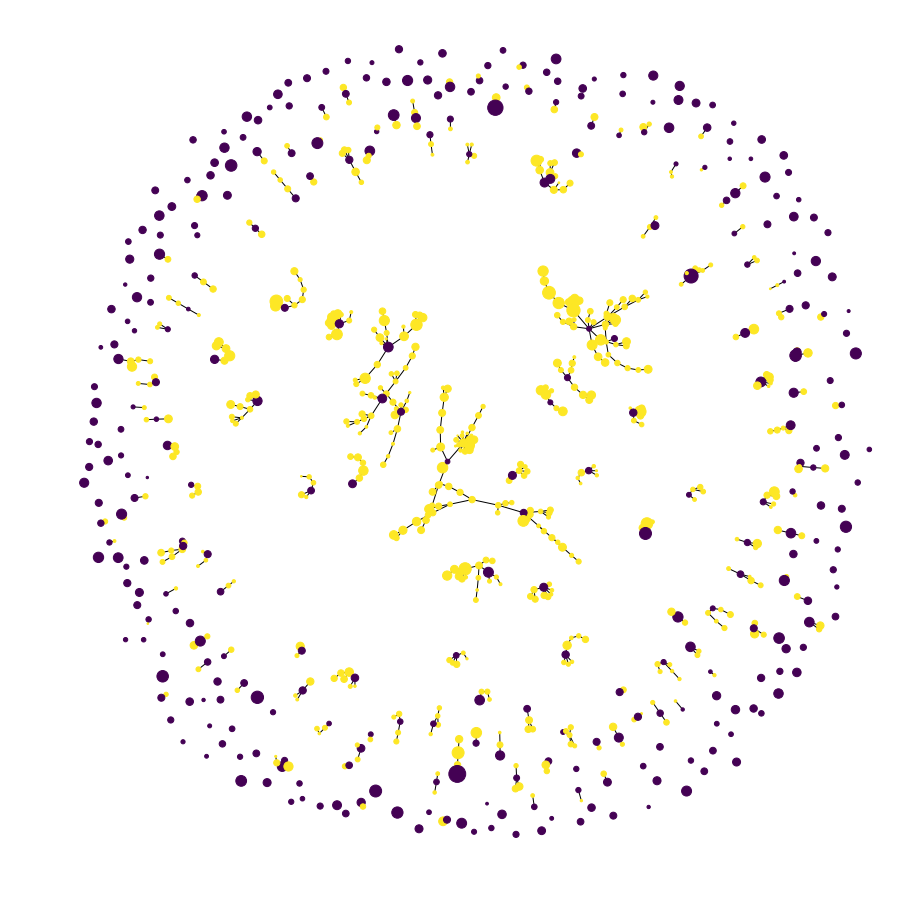

In [206]:
analyse_relations(1110)

##### Extract numeric features and get correlations

In [ ]:
# TODO:
feature_names = ['text_length', 'full_responses', 'direct_responses', 'names_of_politicians', 'upvotes', 'authors_comments', 'popular_topics']  # popular_topic -> extract top words from its WordCloud
comments_features = []

# TODO: Visualize correlations

In [1]:
# TODO: Most common phrase
# TODO: Cut last year? Which is the biggest timespan between date of article and comment
# TODO: Writing comments vs. responding to comments
# TODO: Toxic words
# TODO: Comments per authors .values() plot